In [132]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [133]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import functools
from sklearn import preprocessing
from sklearn import metrics
import seaborn as sns

### Load and Reduce Previous Classifications

In [134]:
# convenience methods for getting column lists
def get_question_columns():
    return ['decals-{}'.format(n) for n in range(10)]  # dont try to reduce multiple choice questions
def get_count_columns(df):
    return list(filter(lambda x: x.endswith('_count') , df.columns.values))
def get_fraction_columns(df):
    return list(filter(lambda x: x.endswith('_fraction') , df.columns.values))
def get_prediction_columns(df):
    return list(filter(lambda x: x.endswith('_prediction') , df.columns.values))
def get_relevant_answers(df, question):
    return list(filter(lambda x: x.startswith(question), get_count_columns(df)))
def get_relevant_answer_fractions(df, question):
    return list(filter(lambda x: x.startswith(question), get_fraction_columns(df)))

In [135]:
decals_dr1_classifications_loc = '/data/galaxy_zoo/weekly_dumps/2017-10-15_galaxy_zoo_decals_classifications.csv'

In [136]:
def get_decals_classifications(classifications_loc):
    df = pd.read_csv(classifications_loc, nrows=None)
    # remove extremely rare answers
    for question in get_question_columns():
        value_counts = df[question].value_counts()
        if value_counts.min() < len(df) * 0.0001: # fewer than 1 in 10,000 most likely beta responses
            df = df[df[question] != value_counts.idxmin()]
    return df

In [137]:
dr1_df = get_decals_classifications(decals_dr1_classifications_loc)

In [138]:
print(dr1_df['decals-0'].value_counts())

a-0    914957
a-1    489894
a-2    312316
Name: decals-0, dtype: int64


In [139]:
decals_dr2_classifications_loc = '/data/galaxy_zoo/weekly_dumps/2017-10-15_galaxy_zoo_decals_dr2_classifications.csv'
dr2_df = get_decals_classifications(decals_dr2_classifications_loc)

In [140]:
print(dr2_df['decals-0'].value_counts())

a-0    1284174
a-1     683790
a-2     507486
Name: decals-0, dtype: int64


In [141]:
# we need to make sure that the questions are the same
for question in ['decals-{}'.format(n) for n in range(10)]:
    dr1_answers = dr1_df[question].dropna().unique()
    dr2_answers = dr2_df[question].dropna().unique()
#     print(question)
#     print(dr1_answers)
#     print(dr2_answers)
    assert all([answer in dr2_answers for answer in dr1_answers])
    assert all([answer in dr1_answers for answer in dr2_answers])

In [142]:
df = pd.concat([dr1_df, dr2_df])

In [175]:
possible_answers = dict(zip(get_question_columns(), [df[question].dropna().unique() for question in get_question_columns()]))
print(possible_answers)

{'decals-0': array(['a-1', 'a-0', 'a-2'], dtype=object), 'decals-1': array(['a-0', 'a-1'], dtype=object), 'decals-2': array(['a-0', 'a-1'], dtype=object), 'decals-3': array(['a-0', 'a-1'], dtype=object), 'decals-4': array(['a-2', 'a-1', 'a-0'], dtype=object), 'decals-5': array(['a-1', 'a-2', 'a-0'], dtype=object), 'decals-6': array(['a-2', 'a-1', 'a-3', 'a-0', 'a-4'], dtype=object), 'decals-7': array(['a-2', 'a-0', 'a-1'], dtype=object), 'decals-8': array(['a-0', 'a-1', 'a-2'], dtype=object), 'decals-9': array(['a-1', 'a-3', 'a-0', 'a-2'], dtype=object)}


In [170]:
print(df['decals-6'].value_counts())

a-1    279539
a-2     68815
a-0     41165
a-3     28136
a-4     25006
Name: decals-6, dtype: int64


In [143]:
def translate_column(df, question_colname):
    
    unique_answers = df[question_colname].dropna().unique()
    print(question_colname, unique_answers)
    count_columns = [question_colname + '_' + answer + '_count' for answer in unique_answers]
    fraction_columns = [question_colname + '_' + answer + '_fraction' for answer in unique_answers]
    total_votes_col = question_colname + '_total_votes'
    
    # remove any of these if they exist already
    df = df.drop(count_columns + fraction_columns + [total_votes_col], errors='ignore', axis=1)

    # get counts
    dummy_df = pd.get_dummies(df[question_colname])
    # append column names with question
    dummy_df = dummy_df.rename(columns=dict(zip(unique_answers, count_columns)))
    
    # dummy_df only includes answers. Add back to original df.
    reduced_df = pd.concat([df.copy(), dummy_df], axis=1)
    
    return reduced_df

In [144]:
questions = get_question_columns()
for question in questions:
    df = translate_column(df, question)
# display(df[['subject_id', 'decals-0', 'decals-0_a-0_count', 'decals-9', 'decals-9_a-0_count']])

decals-0 ['a-1' 'a-0' 'a-2']
decals-1 ['a-0' 'a-1']
decals-2 ['a-0' 'a-1']
decals-3 ['a-0' 'a-1']
decals-4 ['a-2' 'a-1' 'a-0']
decals-5 ['a-1' 'a-2' 'a-0']
decals-6 ['a-2' 'a-1' 'a-3' 'a-0' 'a-4']
decals-7 ['a-2' 'a-0' 'a-1']
decals-8 ['a-0' 'a-1' 'a-2']
decals-9 ['a-1' 'a-3' 'a-0' 'a-2']


In [145]:
def reduce_all_questions(df):
    
    # work out question and columns
    question_columns = get_question_columns()
    count_columns = get_count_columns(df)
    
    # every column ending _count should be added
    count_agg = dict(zip(count_columns, ['sum' for n in range(len(count_columns))]))
    
    # every other column can be dropped
    reduced_df = df.groupby('subject_id').agg(count_agg).reset_index()
    
    # replace all NaN in count columns with 0
    reduced_df = reduced_df.fillna(0)
    
    # calculate total votes and vote fractions
    for question in question_columns:
        relevant_answer_cols = get_relevant_answers(df, question)
        
        total_votes_col = question + '_total_votes'
        reduced_df[total_votes_col] = reduced_df[relevant_answer_cols].sum(axis=1)
        
        fraction_columns = list(map(lambda x: x + '_fraction', relevant_answer_cols))
        for n in range(len(relevant_answer_cols)):
            reduced_df[fraction_columns[n]] = reduced_df[relevant_answer_cols[n]] / reduced_df[total_votes_col]
    
        # replace all NaN caused by no votes for that question (rare) with 0
        reduced_df[fraction_columns] = reduced_df[fraction_columns].fillna(0)

    return reduced_df

In [146]:
reduced_df = reduce_all_questions(df)

In [147]:
# check that there are no NaN values
counts = get_count_columns(reduced_df)
assert len(reduced_df[counts]) == len(reduced_df[counts].dropna(how='any'))

fractions = get_fraction_columns(reduced_df)
assert len(reduced_df[fractions]) == len(reduced_df[fractions].dropna(how='any'))

In [148]:
print(get_relevant_answers(reduced_df, 'decals-0'))

['decals-0_a-0_count', 'decals-0_a-1_count', 'decals-0_a-2_count']


### Load Previous Subject Manifest

(decals) subjects is all of the Ouroborous subjects, cleaned up and selected by survey=decals

In [149]:
decals_subjects_loc = '/data/galaxy_zoo/decals/subjects/decals_dr1_and_dr2.csv'
subjects = pd.read_csv(decals_subjects_loc)

/data/anaconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [150]:
subjects.head()

,_id,absolute_size,background,bad_image,band,bands,camera,counters,data_release,dec,...,sdss_dr12_objid,sdss_dr7_id,sdss_dr8_id,sdss_id,sfr,simulation,snapshot,subdir,subhalo_id,survey
0,ObjectId(55a7d7a27a726119cd000000),6.302853,NaN,NaN,NaN,NaN,NaN,"{""feature"": 0, ""smooth"": 0, ""star"": 0}",DR1,1.193208,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,decals
1,ObjectId(55a7d7a27a726119cd000001),10.063020,NaN,NaN,NaN,NaN,NaN,"{""feature"": 0, ""smooth"": 0, ""star"": 0}",DR1,1.209493,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,decals
2,ObjectId(55a7d7a27a726119cd000002),3.616176,NaN,NaN,NaN,NaN,NaN,"{""feature"": 0, ""smooth"": 0, ""star"": 0}",DR1,1.140173,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,decals
3,ObjectId(55a7d7a27a726119cd000003),11.591978,NaN,NaN,NaN,NaN,NaN,"{""feature"": 0, ""smooth"": 0, ""star"": 0}",DR1,1.182009,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,decals
4,ObjectId(55a7d7a27a726119cd000004),3.555956,NaN,NaN,NaN,NaN,NaN,"{""feature"": 0, ""smooth"": 0, ""star"": 0}",DR1,1.212554,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,decals


In [151]:
len(subjects)
len(subjects['_id'].unique())

103712

103712

There is one row in the manifest per _id value.

We know from catalog matching that of 104k rows and _id values, 94k have ra/dec near DR5 galaxies

So we expect at least 94k subjects to be both classified and listed in the manifest.

It's a bit odd that some subjects don't have classifications - perhaps these were deleted and not cleaned up.


In [152]:
subjects['subject_id'] = subjects['_id'].apply(lambda x: x[9:-1])

In [153]:
class_with_subject = pd.merge(reduced_df, subjects, on='subject_id', how='inner')
print(len(class_with_subject))

94024


All unique subject_id in classification are in subjects

In [154]:
display(class_with_subject.head())

,subject_id,decals-0_a-0_count,decals-0_a-1_count,decals-0_a-2_count,decals-1_a-0_count,decals-1_a-1_count,decals-2_a-0_count,decals-2_a-1_count,decals-3_a-0_count,decals-3_a-1_count,...,sdss_dr12_objid,sdss_dr7_id,sdss_dr8_id,sdss_id,sfr,simulation,snapshot,subdir,subhalo_id,survey
0,55a7d7a27a726119cd00000b,19,15,11,2,13,1,12,8,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,decals
1,55a7d7a27a726119cd00000c,33,2,6,1,1,0,1,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,decals
2,55a7d7a27a726119cd00000d,36,1,10,0,1,0,1,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,decals
3,55a7d7a27a726119cd00000e,32,15,6,0,15,2,13,8,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,decals
4,55a7d7a27a726119cd00000f,40,6,7,0,6,3,3,0,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,decals


In [155]:
class_with_subject.columns.values

array(['subject_id', 'decals-0_a-0_count', 'decals-0_a-1_count',
       'decals-0_a-2_count', 'decals-1_a-0_count', 'decals-1_a-1_count',
       'decals-2_a-0_count', 'decals-2_a-1_count', 'decals-3_a-0_count',
       'decals-3_a-1_count', 'decals-4_a-0_count', 'decals-4_a-1_count',
       'decals-4_a-2_count', 'decals-5_a-0_count', 'decals-5_a-1_count',
       'decals-5_a-2_count', 'decals-6_a-0_count', 'decals-6_a-1_count',
       'decals-6_a-2_count', 'decals-6_a-3_count', 'decals-6_a-4_count',
       'decals-7_a-0_count', 'decals-7_a-1_count', 'decals-7_a-2_count',
       'decals-8_a-0_count', 'decals-8_a-1_count', 'decals-8_a-2_count',
       'decals-9_a-0_count', 'decals-9_a-1_count', 'decals-9_a-2_count',
       'decals-9_a-3_count', 'decals-0_total_votes',
       'decals-0_a-0_count_fraction', 'decals-0_a-1_count_fraction',
       'decals-0_a-2_count_fraction', 'decals-1_total_votes',
       'decals-1_a-0_count_fraction', 'decals-1_a-1_count_fraction',
       'decals-2_total_vo

In [156]:
test_columns = ['subject_id', 'decals-0_a-0_count', 'decals-0_a-1_count', 'decals-0_a-2_count', 'decals-0_total_votes', 'decals-0_a-0_count_fraction']

### Reduction Complete. What does this mean as classifer?

#### Which answer was predicted?

In [158]:
def get_predictions(df, question):
    
    # if predictions exist, remove them
    df = df.drop([question + '_prediction_conf', question + '_prediction'], axis=1, errors='ignore')

    relevant_fraction_cols = get_relevant_answer_fractions(df, question)  # get fraction cols
    
    df[question + '_prediction_conf'] = df[relevant_fraction_cols].max(axis=1)  # highest value in frac. cols
    
    most_common_answer_col = df[relevant_fraction_cols].idxmax(axis=1) # column with highest value
    most_common_answers = most_common_answer_col.apply(lambda x: x.split('_')[1])  # text answer of that column
    
    df[question + '_prediction'] = most_common_answers

    return df

In [159]:
questions = get_question_columns()
prediction_df = reduced_df.copy()
for question in questions:
    prediction_df = get_predictions(prediction_df, question)

In [160]:
prediction_df.head()
print(get_relevant_answers(prediction_df, question))

,subject_id,decals-0_a-0_count,decals-0_a-1_count,decals-0_a-2_count,decals-1_a-0_count,decals-1_a-1_count,decals-2_a-0_count,decals-2_a-1_count,decals-3_a-0_count,decals-3_a-1_count,...,decals-5_prediction_conf,decals-5_prediction,decals-6_prediction_conf,decals-6_prediction,decals-7_prediction_conf,decals-7_prediction,decals-8_prediction_conf,decals-8_prediction,decals-9_prediction_conf,decals-9_prediction
0,55a7d7a27a726119cd00000b,19,15,11,2,13,1,12,8,5,...,0.500,a-0,0.625,a-1,1.0,a-0,0.842105,a-0,0.676471,a-3
1,55a7d7a27a726119cd00000c,33,2,6,1,1,0,1,0,1,...,0.000,a-0,0.000,a-0,1.0,a-0,0.848485,a-0,0.685714,a-3
2,55a7d7a27a726119cd00000d,36,1,10,0,1,0,1,0,1,...,0.000,a-0,0.000,a-0,0.0,a-0,0.638889,a-0,0.945946,a-3
3,55a7d7a27a726119cd00000e,32,15,6,0,15,2,13,8,7,...,0.875,a-0,0.500,a-1,0.0,a-0,0.500000,a-0,0.914894,a-3
4,55a7d7a27a726119cd00000f,40,6,7,0,6,3,3,0,6,...,0.000,a-0,0.000,a-0,0.0,a-0,0.725000,a-1,0.847826,a-3


['decals-9_a-0_count', 'decals-9_a-1_count', 'decals-9_a-2_count', 'decals-9_a-3_count']


#### Encode predicted class for each question as integer

In [185]:
def get_encoders(df, possible_answers):
    questions = get_question_columns()
    encoders = dict(zip(questions, [preprocessing.LabelEncoder() for question in questions]))
    for question in questions:
        encoders[question] = encoders[question].fit(possible_answers[question])  # fails if a value is never pred.
    return encoders

print(possible_answers['decals-6'])
encoders = get_encoders(prediction_df, possible_answers)
questions = get_question_columns()
for question in questions:
    prediction_df[question + '_prediction_encoded'] = encoders[question].transform(prediction_df[question + '_prediction'])

print(encoders['decals-6'].inverse_transform(4))
prediction_df.head()

['a-2' 'a-1' 'a-3' 'a-0' 'a-4']
a-4


,subject_id,decals-0_a-0_count,decals-0_a-1_count,decals-0_a-2_count,decals-1_a-0_count,decals-1_a-1_count,decals-2_a-0_count,decals-2_a-1_count,decals-3_a-0_count,decals-3_a-1_count,...,decals-0_prediction_encoded,decals-1_prediction_encoded,decals-2_prediction_encoded,decals-3_prediction_encoded,decals-4_prediction_encoded,decals-5_prediction_encoded,decals-6_prediction_encoded,decals-7_prediction_encoded,decals-8_prediction_encoded,decals-9_prediction_encoded
0,55a7d7a27a726119cd00000b,19,15,11,2,13,1,12,8,5,...,0,1,1,0,1,0,1,0,0,3
1,55a7d7a27a726119cd00000c,33,2,6,1,1,0,1,0,1,...,0,0,1,1,1,0,0,0,0,3
2,55a7d7a27a726119cd00000d,36,1,10,0,1,0,1,0,1,...,0,1,1,1,1,0,0,0,0,3
3,55a7d7a27a726119cd00000e,32,15,6,0,15,2,13,8,7,...,0,1,1,0,1,0,1,0,0,3
4,55a7d7a27a726119cd00000f,40,6,7,0,6,3,3,0,6,...,0,1,0,1,1,0,0,0,1,3


#### What's the 'Classifier' Performance?

In [178]:
def fraction_with_correct_answer(row, question):
    return row['{}_{}_count_fraction'.format(question, row[question + '_truth'])]

In [179]:
classifier_df = prediction_df.copy()

# pretend some true values, for now

def fake_news(df, question, encoder):
    df[question + '_truth'] = np.random.choice(df[question + '_prediction'].unique(), size=len(df))
    df[question + '_truth_encoded'] = encoders[question].transform(df[question + '_truth'])
    df[question + '_truth_conf'] = df.apply(fraction_with_correct_answer, question=question, axis=1)
    return df
    
questions = get_question_columns()
for question in questions:
    classifier_df = fake_news(classifier_df, question, encoders[question])
    
classifier_df.head()

,subject_id,decals-0_a-0_count,decals-0_a-1_count,decals-0_a-2_count,decals-1_a-0_count,decals-1_a-1_count,decals-2_a-0_count,decals-2_a-1_count,decals-3_a-0_count,decals-3_a-1_count,...,decals-6_truth_conf,decals-7_truth,decals-7_truth_encoded,decals-7_truth_conf,decals-8_truth,decals-8_truth_encoded,decals-8_truth_conf,decals-9_truth,decals-9_truth_encoded,decals-9_truth_conf
0,55a7d7a27a726119cd00000b,19,15,11,2,13,1,12,8,5,...,0.00,a-1,1,0.0,a-1,1,0.105263,a-3,3,0.676471
1,55a7d7a27a726119cd00000c,33,2,6,1,1,0,1,0,1,...,0.00,a-0,0,1.0,a-0,0,0.848485,a-1,1,0.085714
2,55a7d7a27a726119cd00000d,36,1,10,0,1,0,1,0,1,...,0.00,a-1,1,0.0,a-0,0,0.638889,a-2,2,0.000000
3,55a7d7a27a726119cd00000e,32,15,6,0,15,2,13,8,7,...,0.25,a-0,0,0.0,a-2,2,0.000000,a-3,3,0.914894
4,55a7d7a27a726119cd00000f,40,6,7,0,6,3,3,0,6,...,0.00,a-0,0,0.0,a-2,2,0.025000,a-3,3,0.847826


In [180]:
classifier_df['decals-0_truth_encoded'].value_counts()
classifier_df['decals-0_prediction_encoded'].value_counts()

1    31647
0    31237
2    31140
Name: decals-0_truth_encoded, dtype: int64

0    68155
1    23461
2     2408
Name: decals-0_prediction_encoded, dtype: int64

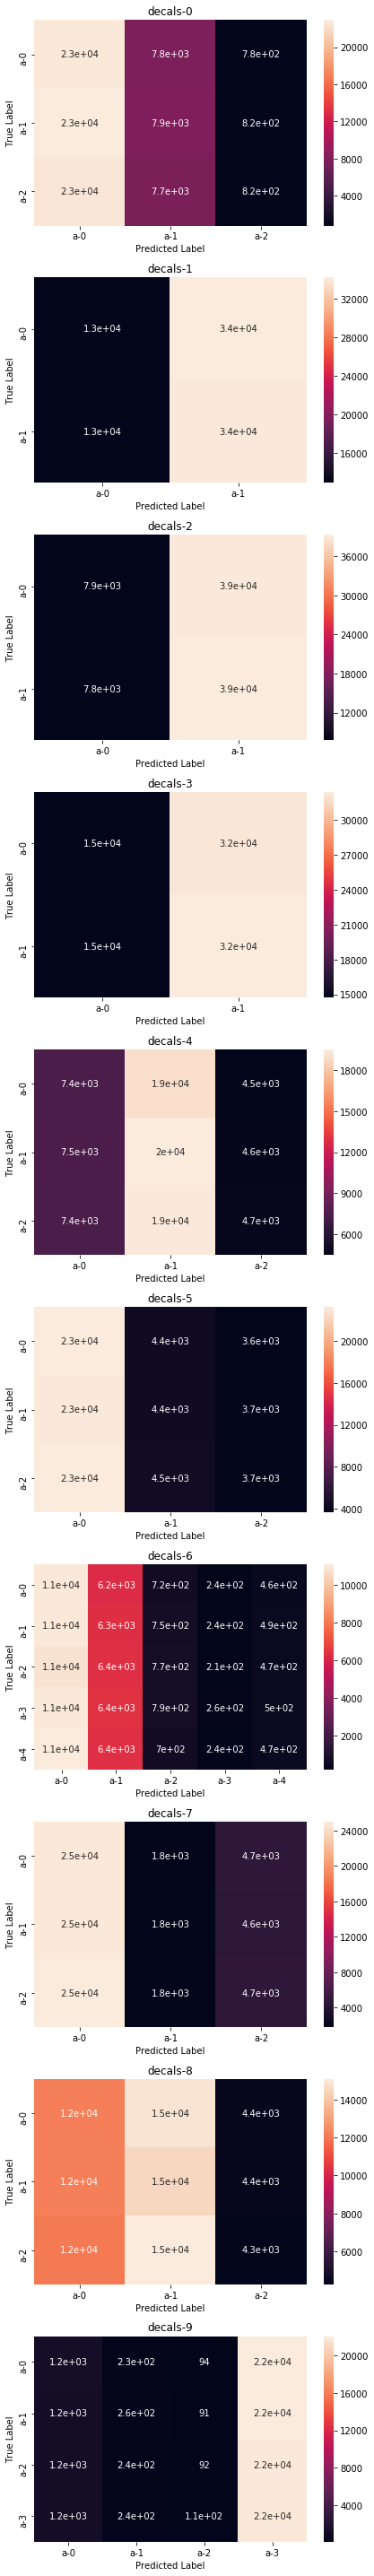

In [187]:
def get_confusion_matrix(df, question, encoder, ax):
    confusion_data = metrics.confusion_matrix(df[question + '_truth_encoded'], df[question + '_prediction_encoded'])
    labels_to_invert = list(range(len(get_relevant_answers(df, question))))
    labels = encoder.inverse_transform(labels_to_invert)  # right num of ints
    df_cm = pd.DataFrame(
        confusion_data,
        index = [i for i in labels],
        columns = [i for i in labels])
    ax = sns.heatmap(df_cm, annot=True, ax=ax)
    _ = ax.set_ylabel('True Label')
    _ = ax.set_xlabel('Predicted Label')
    ax.set_title(question)
    return ax

question_n = len(get_question_columns())
fig, axes = plt.subplots(nrows=question_n, figsize=(6, question_n * 4))
for n, question in enumerate(questions):
    ax = get_confusion_matrix(classifier_df, question, encoders[question], axes[n])
fig.tight_layout()

In [ ]:
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report
print(metrics.classification_report(featured_data['truth_int'], featured_data['prediction_int']))

In [ ]:
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
fpr, tpr, thresholds = metrics.roc_curve(featured_data['truth_int'], featured_data['truth_confidence'], pos_label=1)
plt.plot(fpr, tpr)

In [ ]:
# http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html#sklearn.metrics.precision_recall_curve
precision, recall, thresholds = metrics.precision_recall_curve(featured_data['truth_int'], featured_data['truth_confidence'], pos_label=1)
plt.plot(precision, recall)

In [ ]:
# http://scikit-learn.org/stable/modules/calibration.html#calibration important for analysis later

In [ ]:
pd.get_dummies(featured_data['truth'])  # I should use this for the counting